# Read Sentinel-1 RTC data processed by ASF using `xr.open_mfdataset()`

This notebook demonstrates working with Sentinel-1 RTC imagery that has been processed on the ASF On-Demand server and downloaded locally. 

The access point for data in this notebook is a directory containing un-zipped directories of RTC scenes.

This notebook will detail how to use the xarray function `xr.open_mfdataset()`. While this approach works and is very useful for working with large stacks of data with associated metadata, you will also see an example of the limitations of this approach due to certain characteristics of the dataset. You can read more about `xr.open_mfdataset()` [here](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html).

**Learning goals**:

- Organize large set of geotiff files stored locally
- Read data into memory using Xarray's `open_mfdataset()` method.

## Software and setup

In [1]:
import contextily as cx
import dask
from dask.distributed import Client
from datetime import datetime
from functools import partial
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
from pathlib import Path
import re
import xarray as xr


Initialize a `dask.distributed` client:

```{note} 
On my local machine, I ran into issues initially when the cluster was running on processes rather than threads. This caused system memory issues and many dead kernels. Setting `processes=False` seemed to fix these issues
```

In [2]:
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.86.116:8787/status,
Dashboard: http://192.168.86.116:8787/status,Workers: 1
Total threads: 14,Total memory: 38.76 GiB
Status: running,Using processes: False
Comm: inproc://192.168.86.116/1052/1,Workers: 1
Dashboard: http://192.168.86.116:8787/status,Total threads: 14
Started: Just now,Total memory: 38.76 GiB
Comm: inproc://192.168.86.116/1052/4,Total threads: 14
Dashboard: http://192.168.86.116:38499/status,Memory: 38.76 GiB
Nanny: None,


Open the dask dashboard at the link above to monitor task progress.

### Organize file paths

Set up some string variables for directory paths. We need to pass `xr.open_mfdataset()` a list of all files to read in. Currently, the file structure is organized so that each scene has its own sub-directory within `asf_rtcs`. Within each sub-directory are several files - we want to extract the GeoTIFF files containing RTC imagery for the VV and VH polarizations for each scene as well as the layover-shadow mask for each scene. The function `extract_fnames()` takes a path to the directory containing the sub-directories for all scenes and returns a list of the filenames for VV-polarization GeoTIFF files, VH-polarization GeoTIFF files and layover-shadow mask GeoTIFF files. 

In [3]:
cwd = pathlib.Path.cwd()
tutorial2_dir = pathlib.Path(cwd).parent

In [4]:
timeseries_type = "full"
path_to_rtcs = f"tutorial2/data/{timeseries_type}_timeseries/asf_rtcs"

In [5]:
# Path to directory holding downloaded data
s1_asf_data = os.path.join(str(cwd.parents[1]), path_to_rtcs)
scenes_ls = os.listdir(s1_asf_data)

In [6]:
def extract_fnames(data_path: str, scene_name: str, variable: str) -> list:
    """
    Extract filenames for a specific variable from a given scene directory.

    Parameters
    ----------
    data_path : str
        Path to the directory containing scene sub-directories.
    scene_name : str
        Name of the scene sub-directory.
    variable : str
        Variable type to extract filenames for. Options are 'vv', 'vh', 'ls_map', or 'readme'.

    Returns
    -------
    list
        List of filenames matching the specified variable within the scene directory.
    """
    # Make list of files within each scene directory in data directory
    scene_files_ls = os.listdir(os.path.join(data_path, scene_name))

    if variable in ['vv', 'vh']:
        scene_files = [fname for fname in scene_files_ls if fname.endswith(f"_{variable.upper()}.tif")]
    
    elif variable == 'ls_map':
        scene_files = [fname for fname in scene_files_ls if fname.endswith(f"_ls_map.tif")]
    
    elif variable == 'readme':
        scene_files = [file for file in scene_files_ls if file.endswith("README.md.txt")]
   
    return scene_files

In [7]:
print(extract_fnames(s1_asf_data, scenes_ls[0], 'vv'))
print(extract_fnames(s1_asf_data, scenes_ls[0], 'vh'))
print(extract_fnames(s1_asf_data, scenes_ls[0], 'ls_map'))
print(extract_fnames(s1_asf_data, scenes_ls[0], 'readme'))

['S1A_IW_20220214T121353_DVP_RTC30_G_gpuned_51E7_VV.tif']
['S1A_IW_20220214T121353_DVP_RTC30_G_gpuned_51E7_VH.tif']
['S1A_IW_20220214T121353_DVP_RTC30_G_gpuned_51E7_ls_map.tif']
['S1A_IW_20220214T121353_DVP_RTC30_G_gpuned_51E7.README.md.txt']


In [8]:
def make_filepath_lists(asf_s1_data_path: str, variable: str) -> tuple:
    """
    Generate lists of file paths and acquisition dates for a specific variable from Sentinel-1 RTC data.

    Parameters
    ----------
    asf_s1_data_path : str
        Path to the directory containing scene sub-directories.
    variable : str
        Variable type to extract filenames for. Options are 'vv', 'vh', 'ls_map', or 'readme'.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - fpaths (list of str): List of full file paths for the specified variable.
        - dates_ls (list of str): List of acquisition dates corresponding to each file path.
    """
    scenes_ls = os.listdir(asf_s1_data_path)

    fpaths, dates_ls = [], []

    for element in range(len(scenes_ls)):
        # Extract filenames of each file of interest
        files_of_interest = extract_fnames(asf_s1_data_path, scenes_ls[element], variable)
        # Make full path with filename for each variable
        path = os.path.join(asf_s1_data_path, scenes_ls[element], files_of_interest[0])
        # Extract dates to make sure dates are identical across variable lists
        date = pathlib.Path(path).stem.split("_")[2]

        dates_ls.append(date)
        fpaths.append(path)

    return (fpaths, dates_ls)

In [9]:
def create_filenames_dict(rtc_path: str, variables_ls: list) -> dict:
    """
    Create a dictionary of filenames for specified variables from Sentinel-1 RTC data.

    Parameters
    ----------
    rtc_path : str
        Path to the directory containing scene sub-directories.
    variables_ls : list
        List of variable types to extract filenames for. Options are 'vv', 'vh', 'ls_map', or 'readme'.

    Returns
    -------
    dict
        A dictionary where keys are variable names and values are lists of file paths for the specified variables.

    Raises
    ------
    AssertionError
        If the dates are not identical across all lists or if the length of each variable list is not the same.
    """
    keys, filepaths, dates = [], [], []
    for variable in variables_ls:
        keys.append(variable)

        filespaths_list, dates_list = make_filepath_lists(rtc_path, variable)
        filepaths.append(filespaths_list)
        dates.append(dates_list)
    
    # Make dict of variable names (keys) and associated filepaths
    filepaths_dict = dict(zip(keys, filepaths))

    # Make sure that dates are identical across all lists
    assert all(lst == dates[0] for lst in dates) == True
    # Make sure length of each variable list is the same 
    assert len(list(set([len(v) for k, v in filepaths_dict.items()]))) == 1

    return filepaths_dict

In [10]:
filepaths_dict = create_filenames_dict(s1_asf_data, ['vv','vh','ls_map','readme'])

`filepaths_dict` has a key for each file type:

In [11]:
filepaths_dict.keys()

dict_keys(['vv', 'vh', 'ls_map', 'readme'])

## Read files using `xr.open_mfdataset()`

The `xr.open_mfdataset()` function reads multiple files (in a directory or from a list) and combines them to return a single `xr.Dataset` or `xr.DataArray`. To use the function, specify parameters such as how the files should be combined as well as any preprocessing to execute on the original files. This example will demonstrate a workflow for using `open_mfdataset()` to read in three stacks of roughly 100 RTC images.

Here is an example of reading a single file with `xr.open_datatset()`:

In [12]:
ds1 = xr.open_dataset(filepaths_dict['vv'][0])
ds1

<xarray.Dataset> Size: 302MB
Dimensions:      (band: 1, x: 9851, y: 7656)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 79kB 4.152e+05 4.152e+05 ... 7.106e+05 7.107e+05
  * y            (y) float64 61kB 3.137e+06 3.137e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 302MB ...

We're missing a lot of important metadata such as the type of data (VV, VH or ls_map) and the time associated with the observation. This is stored in the filename. We will use a preprocess function to tell Xarray how to parse the filename and organize the related metadata for each file in the list passed to `xr.open_mfdataset()`. The preprocess function will use `parse_fname_metadata()`, defined below:

In [13]:
def parse_fname_metadata(input_fname: str) -> dict:
    """Function to extract information from filename and separate into expected variables based on a defined schema."""
    # Define schema
    schema = {
        "sensor": (3, r"S1[A-B]"),  # schema for sensor
        "beam_mode": (2, r"[A-Z]{2}"),  # schema for beam mode
        "acq_date": (15, r"[0-9]{8}T[0-9]{6}"),  # schema for acquisition date
        "pol_orbit": (3, r"[A-Z]{3}"),  # schema for polarization + orbit type
        "terrain_correction_pixel_spacing": (
            5,
            r"RTC[0-9]{2}",
        ),  # schema for terrain correction pixel spacing
        "processing_software": (
            1,
            r"[A-Z]{1}",
        ),  # schema for processing software (G = Gamma)
        "output_info": (6, r"[a-z]{6}"),  # schema for output info
        "product_id": (4, r"[A-Z0-9]{4}"),  # schema for product id
        "prod_type": ((2, 6), (r"[A-Z]{2}", r"ls_map")),  # schema for polarization type
    }

    # Remove prefixs
    input_fname = input_fname.split("/")[-1]
    # Remove file extension if present
    input_fname = input_fname.removesuffix(".tif")
    # Split filename string into parts
    parts = input_fname.split("_")

    # l-s map objects have an extra '_' in the filename. Remove/combine parts so that it matches schema
    if parts[-1] == "map":
        parts = parts[:-1]
        parts[-1] = parts[-1] + "_map"

    # Check that number of parts matches expected schema
    if len(parts) != len(schema):
        raise ValueError(
            f"Input filename does not match schema of expected format: {parts}"
        )

    # Create dict to store parsed data
    parsed_data = {}

    # Iterate through parts and schema
    for part, (name, (length_options, pattern_options)) in zip(parts, schema.items()):
        # In the schema we defined, items have an int for length or a tuple (when there is more than one possible lenght)
        # Make the int lengths into tuples
        if isinstance(length_options, int):
            length_options = (length_options,)
        # Same as above for patterns
        if isinstance(pattern_options, str):
            pattern_options = (pattern_options,)

        # Check that each length of each part matches expected length from schema
        if len(part) not in length_options:
            raise ValueError(f"Part {part} does not have expected length {len(part)}")
        # Check that each part matches expected pattern from schema
        if not any(re.fullmatch(pattern, part) for pattern in pattern_options):
            raise ValueError(
                f"Part {part} does not match expected patterns {pattern_options}"
            )

        # Special handling of a part (pol orbit) that has 3 types of metadata
        if name == "pol_orbit":
            parsed_data.update(
                {
                    "polarization_type": part[:1],  # Single (S) or Dual (D) pol
                    "primary_polarization": part[1:2],  # Primary polarization (H or V)
                    "orbit_type": part[
                        -1
                    ],  # Precise (p), Restituted (r) or Original predicted (o)
                }
            )
        # Format string acquisition date as a datetime time stamp
        elif name == "acq_date":
            parsed_data[name] = pd.to_datetime(part, format="%Y%m%dT%H%M%S")
        # Expand multiple variables stored in output_info string part
        elif name == "output_info":
            output_info_keys = [
                "output_type",
                "output_unit",
                "unmasked_or_watermasked",
                "notfiltered_or_filtered",
                "area_or_clipped",
                "deadreckoning_or_demmatch",
            ]

            output_info_values = [part[0], part[1], part[2], part[3], part[4], part[-1]]

            parsed_data.update(dict(zip(output_info_keys, output_info_values)))

        else:
            parsed_data[name] = part

    # Because we have already addressed product type in the variable names
    prod_type = parsed_data.pop("prod_type")
    return parsed_data

Now that we've written a function to create a dictionary of relevant metadata extracted from a filename, we need to use it within a preprocess function. Preprocess functions ingest and return `xr.Dataset` or `xr.DataArray` objects; in other words, they act on each unit passed to `open_mfdataset()`. Your preprocess function should contain all of the steps that must be applied to a single file/`xr.Dataset` object to end up with an analysis-ready cube. The `preprocess` function below:
- Renames the data variable from `'band_data'` to a descriptive name,
- Extracts the file name associated with the `xr.Dataset` (from the object's encoding),
- Parses information stored in the filename and adds it as an `attrs` dictionary,
- Extracts coordinate reference system metadata,
- Reshapes the dataset into a 3-dimensional `x,y,time` cube

In [14]:
def preprocess(ds_orig: xr.DataArray, variable:str):
    """function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think?
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI?"""

    # fname_ls = []

    ds = ds_orig.copy()
    ds = ds.rename({"band_data": variable}).squeeze()

    # vv_fn = da_orig.encoding['source'][113:]
    vh_fn = os.path.basename(ds_orig["band_data"].encoding["source"])
    # print('fname: ', vv_fn)

    attrs_dict = parse_fname_metadata(vh_fn)


    # link the strings for each of the above variables to their full names (from README, commented above)
    # eg if output_type=g, should read 'gamma'

    ds.attrs = attrs_dict

    utm_zone = ds.spatial_ref.attrs["crs_wkt"][17:29]
    epsg_code = ds.spatial_ref.attrs["crs_wkt"][589:594]

    ds.attrs["utm_zone"] = utm_zone
    ds.attrs["epsg_code"] = f"EPSG:{epsg_code}"

    date = ds.attrs["acq_date"]

    ds = ds.assign_coords({"acq_date": date})
    ds = ds.expand_dims("acq_date")
    ds = ds.drop_duplicates(dim=["x", "y"])
    return ds  

Create the wrapper function for each variable:

In [15]:
preprocess_vh_partial = partial(preprocess, variable='vh')
preprocess_vv_partial = partial(preprocess, variable='vv')
preprocess_ls_partial = partial(preprocess, variable='ls_map')

### An example of complicated chunking

First, let's call `xr.open_mfdataset()` with the argument `chunks='auto'`. This will read in a dask array where ideal chunk sizes are selected based off the array size, it will attempt to have chunk sizes where bytes are equal to the configuration value for array chunk size. More about that [here](https://docs.dask.org/en/stable/array-chunks.html#automatic-chunking). You can check the configuration value for an array chunk size with the code below: 

In [16]:
dask.config.get("array.chunk-size")

'128MiB'

In [17]:
asf_vh = xr.open_mfdataset(
    paths=filepaths_dict['vh'],
    preprocess=preprocess_vh_partial,
    chunks="auto",
    engine="rasterio",
    data_vars="minimal",
    coords="minimal",
    concat_dim="acq_date",
    combine="nested",
    parallel=True,
)

In [18]:
asf_vv = xr.open_mfdataset(
    paths=filepaths_dict['vv'],
    preprocess=preprocess_vv_partial,
    chunks="auto",
    engine="rasterio",
    data_vars="minimal",
    coords="minimal",
    concat_dim="acq_date",
    combine="nested",
    parallel=True,
)

In [19]:
asf_ls = xr.open_mfdataset(
    paths=filepaths_dict['ls_map'],
    preprocess=preprocess_ls_partial,
    chunks="auto",
    engine="rasterio",
    data_vars="minimal",
    coords="minimal",
    concat_dim="acq_date",
    combine="nested",
    parallel=True,
)

If we take a look at the `asf_vh` object we just created (click the stack icon on the right of the `vh` variable tab), we see that the chunking along the x and y dimensions is quite complicated. This isn't ideal because it can create problems like excessive communication between workers (and a lot of memory usage) down the line when we perform non-lazy operations. It seems like the `'auto'` chunking is applied to the top layer (file) of the dataset, but because the spatial footprint of each file is not the same, the 'auto' chunking does not persist through layers and we end up with the funky layout in the object above. 

Ensure that each of the three objects have the same coordinate dimensions so that they can be combined:

In [21]:
assert asf_vh.dims == asf_vv.dims == asf_ls.dims

assert asf_ls.acq_date.equals(asf_vv.acq_date)
assert asf_ls.acq_date.equals(asf_vh.acq_date)

assert asf_vh.x.equals(asf_vv.x)
assert asf_vh.x.equals(asf_ls.x)

assert asf_vh.y.equals(asf_vv.y)
assert asf_vh.y.equals(asf_ls.y)

Merge the VH, VV and layover-shadow mask objects into one `xr.Dataset`:

In [22]:
asf_ds = xr.Dataset(
    {"vv": asf_vv.vv, "vh": asf_vh.vh, "ls": asf_ls.ls_map}
)
asf_ds

<xarray.Dataset> Size: 289GB
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 107kB 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 824B 2022-02-14T12:13:53 ... 2022-...
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    vv           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 3753, 4861), meta=np.ndarray>
    vh           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 3753, 4861), meta=np.ndarray>
    ls           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 3753, 4861), meta=np.ndarray>

If you take a look at the `acq_date` coordinate, you will see that they are not in order. Let's sort by the `acq_date` (time) dimension using xarray `.sortby()`:

In [23]:
asf_ds_sorted = asf_ds.sortby(asf_ds.acq_date)
asf_ds_sorted

<xarray.Dataset> Size: 289GB
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 107kB 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022-...
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    vv           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 3753, 4861), meta=np.ndarray>
    vh           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 3753, 4861), meta=np.ndarray>
    ls           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 3753, 4861), meta=np.ndarray>

How large is this object?

In [24]:
asf_ds_sorted.nbytes/1e9

288.594268176

## Clip stack to AOI using `rioxarray.clip()`

This is a pretty unwieldy object (nearly 300 GB). Let's subset it down to just the area we want to focus on. Read in the following GeoJSON to clip the dataset to the area of interest we'll be using in this tutorial. This AOI covers a region in the central Himalaya near the Chinese border. We will use the `rioxarray.clip()` function which you can read more about [here](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html).


In [25]:
pc_aoi = gpd.read_file(
    "https://github.com/e-marshall/sentinel1_rtc/raw/main/hma_rtc_aoi.geojson"
)
pc_aoi

,geometry
0,"POLYGON ((619420.000 3089790.000, 628100.000 3..."


In [26]:
pc_aoi.explore()

Clip the object:

In [27]:
asf_clip = asf_ds_sorted.rio.clip(pc_aoi.geometry, pc_aoi.crs)

Check the size of the clipped object:

In [28]:
asf_clip.nbytes / 1e9 #units are GB

0.141948568

In [29]:
asf_clip

<xarray.Dataset> Size: 142MB
Dimensions:      (x: 290, y: 396, acq_date: 103)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.09e+06 3.09e+06 ... 3.102e+06 3.102e+06
  * acq_date     (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022-...
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    vv           (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls           (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [30]:
# we don't want to compute this right now, will kill kernel
#asf_clip_load = asf_clip.compute()

The dataset is published as gamma-nought values on the power scale. This is useful for performing statistical analysis but not always for visualization. We convert to decibel scale (sigma-nought) in order to visualize variability in backscatter more easily. Read more about scales used to represent SAR data [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#sar-scales).

In [31]:
def power_to_db(input_arr):
    return 10 * np.log10(np.abs(input_arr))

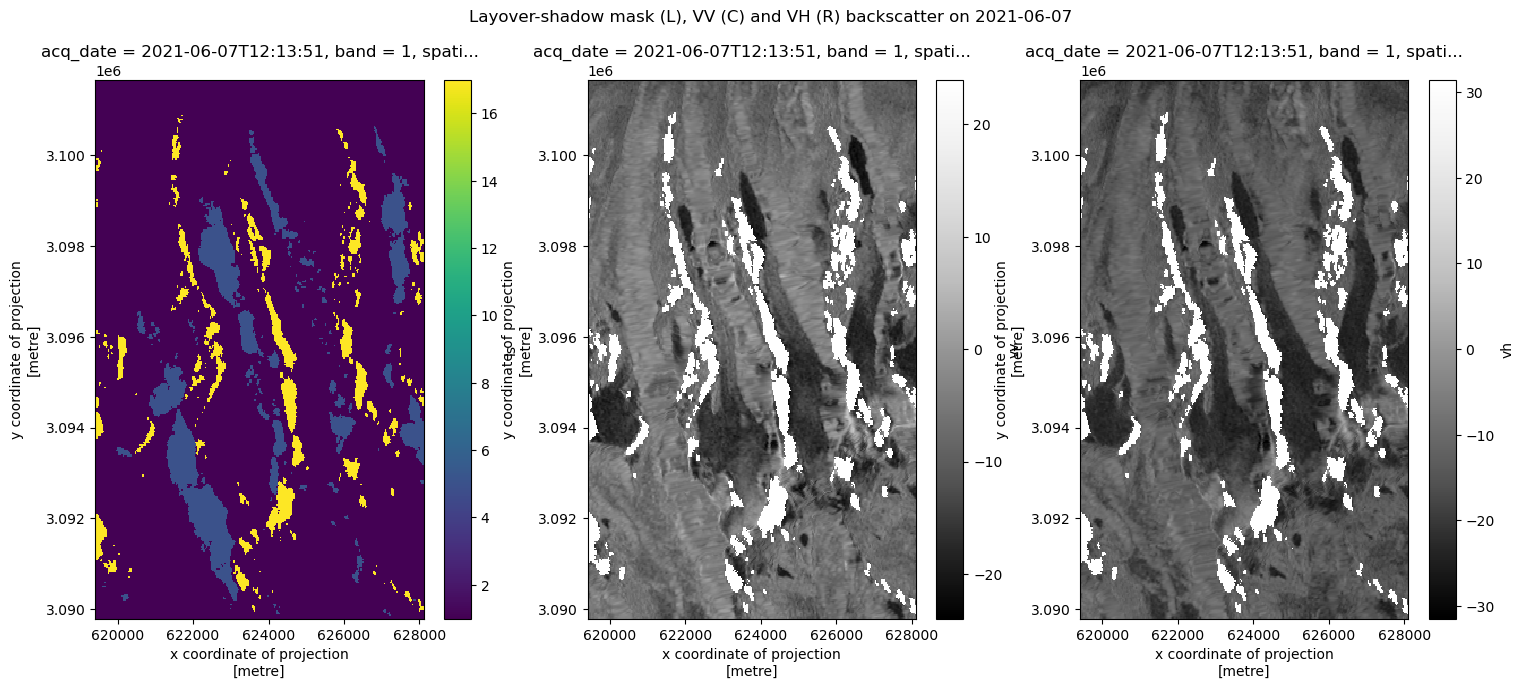

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 7))

asf_clip.isel(acq_date=10).ls.plot(ax=axs[0])
power_to_db(asf_clip.isel(acq_date=10).vv).plot(ax=axs[1], cmap=plt.cm.Greys_r)
power_to_db(asf_clip.isel(acq_date=10).vh).plot(ax=axs[2], cmap=plt.cm.Greys_r)
fig.suptitle(
    f"Layover-shadow mask (L), VV (C) and VH (R) backscatter on {str(asf_clip.isel(acq_date=10).acq_date.data)[:-19]}"
);

## Wrap-up

The `xr.open_mfdataset()` approach is very useful for reading in large amounts of data from a number of distributed files very efficiently. It's especially helpful that the `preprocess()` function allows a large degree of customization for how the data is read in, and that the appropriate metadata is preserved as individual `xr.DataArrays` are organized into data cubes and we have to do very little further work of organizing metadata. 

However, due to the nature of this stack of data, where each time-element of the stack covers a common region of interest but does not have a uniform spatial footprint, this approach is not very computationally efficient. We are reading in a vast footprint of data to subset it to a much smaller area. While it is able to execute on this machine, a more computationally-intensive workflow would fail. 

Another approach we can try is to use GDAL VRT objects. GDAL VRT objects create an xml file from a list of GeoTIFF files. The xml contains a mapping of all of the specified raster files so that we essentially have the spatial information that would have been used to create the full data object, and all of the information we need for a clip. VRT objects are able to handle the mismatch of grids within the stack of files, so does not encounter the memory issues that we get when trying the `xr.open_mfdataset()` approach with dask. 